In [1]:
# General imports
import numpy as np
import sys
basepath = "../"
sys.path.insert(0, basepath)

In [2]:
# Stuff for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["font.size"]=18
mpl.rcParams["font.family"]="sans-serif"
mpl.rcParams["text.usetex"]=True
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [3]:
#  Load the 5BZCat catalog
from lib.data import load_5bzcat, catbins, load_hotspots
dpath = "/Users/chiarabellenghi/PointSource/blazar_hotspots_correlation/data/"

cat = load_5bzcat(dpath)

# Load the hotspot list
hotspots = load_hotspots(dpath, hemisphere='south')

Load 5bzcat.csv
	Found 3469 sources


In [4]:
# Import stuff for the correlation analysis
from lib.correlation import Correlator, EventSample

In [6]:
# Initialize the Correlator object and the sample of hotspots to analyse.
# Note that catbins is useless for our analysis but the framework still requires it.
# scramble=0 will generate the pseudo experiment by scrambling the position of the sources only.
# boots=6 will generate the trial taking care of preserving the number of source,
# the portion of the sky and the latitude cut.
seed = 0
C = Correlator(
    cat, bins=catbins[-1],
    seed=seed,
    dec_range=(np.radians(-85),np.radians(-5)),
    mlat=np.radians(10),
    scramble=0, boots=6)
hs_sample = EventSample(hotspots)
C.add_primary('hotspots', hs_sample)

# Compute trials for the best fit point in Sara Buson et al 2022 ApJL 933 L43
C.logpVal_thr = 4.0
sigma = 0.55
hs_sample.add_sigma_field(np.radians(sigma))

# The max_shift argument scrambles the sources within a maximum distance
# from the original position.
trials = C.trials(n_trials=5000, max_shift=np.radians(10)).astype(int)[:,0]

- Setting galactic plane width to 10.0deg
Set scrambling to catalogue
Catalogue: 3469 sources
Applying cuts to the source catalogue:
	Sources in declination range: [-85.  -5.] degrees: 1214.
	Applying galactic plane cut...
	After galactic plane cut: 1177
	1177 sources above 0.00 (100.00%)
Remove sources that are in no bin:   0.00%
Analysis - Initialize with seed 0
Applying cuts to the event sample:
	Events in [-85.  -5.] degrees: 926
	Applying galactic plane cut...
	After galactic plane cut: 774
After the cut(s), 774 hotspots will be analysed.
	Applying the pvalue threshold cut...
	Spots with -log10p > 4.0: 19
After the cut(s), 19 hotspots will be analysed.
-- Calling function trials of <lib.correlation.Correlator object at 0x132eefee0>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


--> Time (<lib.correlation.Correlator object at 0x132eefee0>, trials):  0d  0: 2:18.61


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  2.3min finished


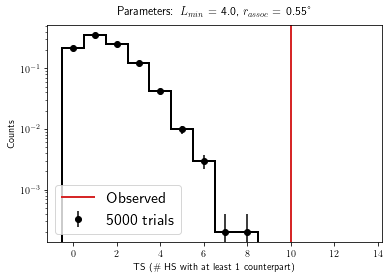

In [7]:
observed_ts = 10

fig,ax = plt.subplots(figsize=(6,4))

counts, bins = np.histogram(trials, bins=np.arange(0,15))
binc = 0.5 * (bins[1:] + bins[:-1])-.5
counts_norm = counts/np.sum(counts)
ax.errorbar(binc, counts_norm, yerr=[np.sqrt(counts)/np.sum(counts),np.sqrt(counts)/np.sum(counts)],
             fmt="o", color="k", zorder=10,
             label=f"{trials.size} trials"
            )
ax.hist(binc, bins-.5, weights=counts_norm, histtype='step', color='k', lw=2)
ax.axvline(observed_ts, color="tab:red", label="Observed", lw=2)

ax.set_yscale('log')

ax.set_title(f"Parameters: $L_{{min}}$ = {C.logpVal_thr}, $r_{{assoc}}$ = {sigma}°", pad=10)
ax.set_xlabel("TS (\# HS with at least 1 counterpart)")
ax.set_ylabel("Counts")

ax.legend(frameon=True, fontsize=16)